# NLP Disaster Tweets Kaggle Mini-Project

The purpose of this project is to predict whether there is a disaster or not from the provided tweets in the dataset.

The dataset has 7,613 tweets in total. Each of the tweets has the columns or features `id`, `keyword`, `location`, `text` and `target`. The column `target` has two values: `0` for 'Non-Disaster' and `1` for 'Disaster'.

## Summary

Only `text` and `target` are used for training models. After EDA and data cleansing, we created a CNN model and a multi-channel CNN model in this project.

**the validation accuracy**

- the CNN model: around 80%
- the multi-channel CNN model: around 80%

Both of the CNN model and the multi-channel CNN model are as good: *the CNN model (the simpler one) is selected for our final model*.

##  Table of Contents

1. Importing Libraries and Dataset

2. Exploring Data

3. Cleansing Data

4. Analyzing Data

5. Preprocessing Data

6. Training Models

7. Discussion

## 1. Importing Libraries and Dataset

### Importing Libraries

First, we will import the libraries to be used in this project.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.merge import concatenate
from keras.callbacks import *
from keras.layers import *
from keras.models import Sequential, Model
import kerastuner as kt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
import string
import re

import warnings
warnings.filterwarnings('ignore')

### Importing the Data

Second, we will import tha train dataset.

In [2]:
data = pd.read_csv('../input/nlp-getting-started/train.csv')

Showing the 10 rows in the dataset.

In [3]:
data.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


Showing the brief summary of the dataset.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


The column `id` have to be removed because it can influence the result even though it is just random numbers.
We also remove the columns `keyword` and `location` as they have a lot of`null` values and are of little use.

We only need the columns `text` and `target` in this project.

In [5]:
data = data[['text','target']]
data.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


## 2. Exploring Data

### Showing the Number of Non-Disaster and Disaster Tweets

We will show the number of the categories (Non-Disaster and Disaster).

The number of Non-Disaster tweets is 1,000 more than that of Disaster ones. But this is not a large problem because the number of tweets in both of the categories is large enough.

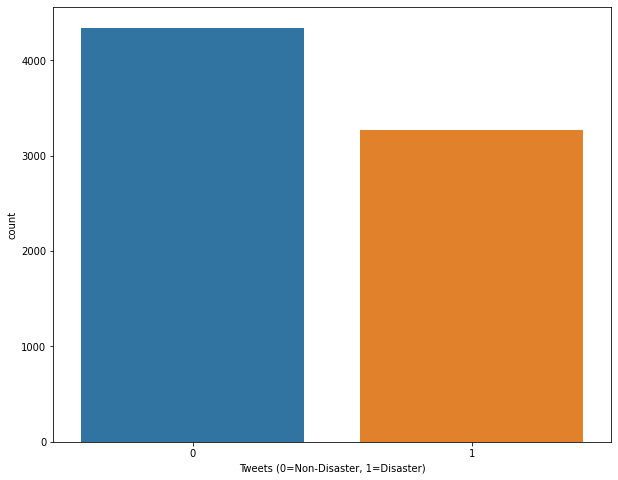

In [6]:
plt.figure(figsize=(10,8))
ax = sns.countplot(x='target', data=data)

ax.set(xlabel='Tweets (0=Non-Disaster, 1=Disaster)')
plt.show()

### Showing the Length of Tweets

We will show the length of tweets in both of the categories.

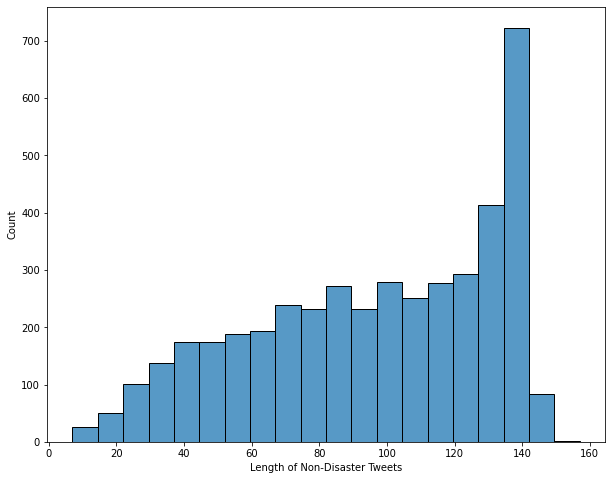

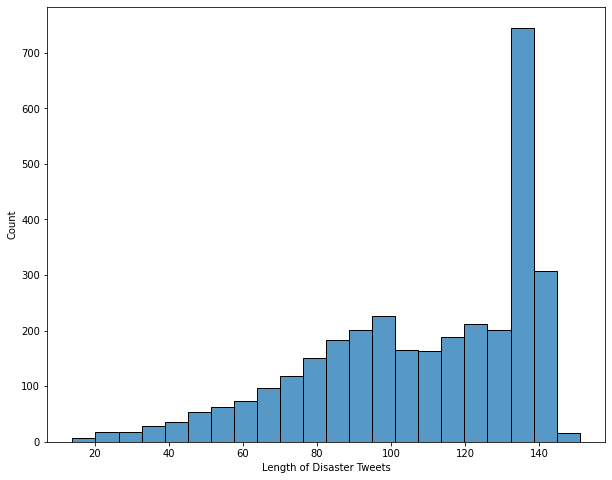

In [7]:
len_of_non_disaster = data[data['target']==0]['text'].map(lambda x : len(x))
len_of_disaster = data[data['target']==1]['text'].map(lambda x : len(x))

len_data = {
    'len_of_non_disaster': len_of_non_disaster,
    'len_of_disaster': len_of_disaster
}

# non_disaster
plt.figure(figsize=(10,8))
ax = sns.histplot(data=len_data, x='len_of_non_disaster')
ax.set(xlabel='Length of Non-Disaster Tweets')
plt.show()
# disaster
plt.figure(figsize=(10,8))
ax = sns.histplot(data=len_data, x='len_of_disaster')
ax.set(xlabel='Length of Disaster Tweets')
plt.show()

From the plot, we can say this:
- the number ratio of Disaster tweets between the length of 100 and 130 is smaller than that of Non-Disaster ones
- the number ratio of Disaster tweets more than the length of 140 is larger than that of Non-Disaster ones

#### Comparing the Mean and Median

We will compare the mean and median in the length of tweets.

In [8]:
print('the length of Non-Disaster tweets. mean={}, median={}'.format(np.mean(len_of_non_disaster), np.median(len_of_non_disaster)))
print('the length of Disaster tweets. mean={}, median={}'.format(np.mean(len_of_disaster), np.median(len_of_disaster)))

the length of Non-Disaster tweets. mean=95.70681713496084, median=101.0
the length of Disaster tweets. mean=108.11342097217977, median=115.0


We can say from the result
- the length of Disaster tweets is longer than that of Non-Disaster tweets in both mean and median

### Showing the Length of Words in Tweets

Now, we will check the length of words in tweets.

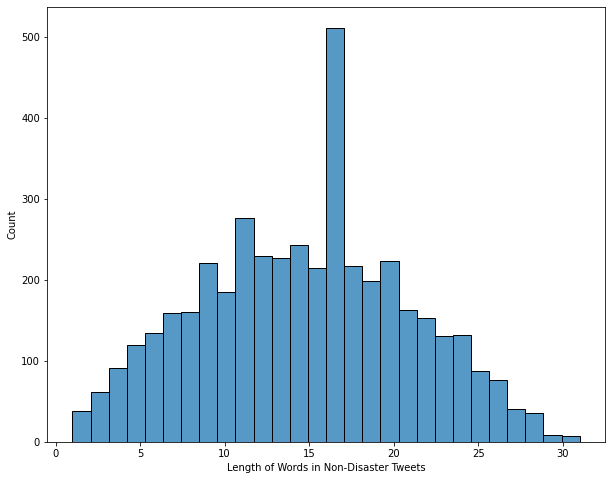

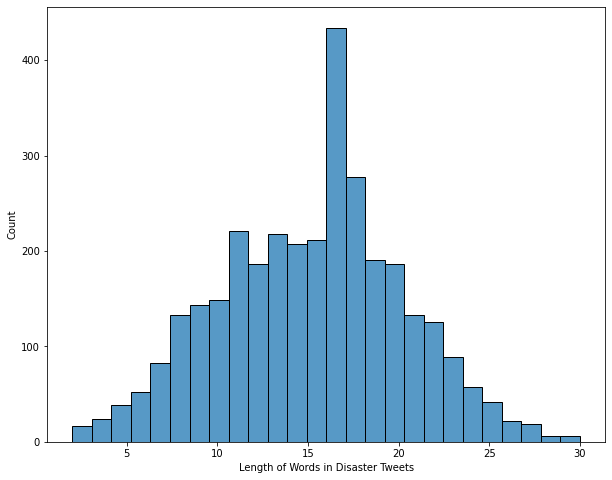

In [9]:
len_of_words_non_disaster = data[data['target']==0]['text'].str.split().map(lambda x : len(x))
len_of_words_disaster = data[data['target']==1]['text'].str.split().map(lambda x : len(x))

len_words_data = {
    'len_of_words_non_disaster': len_of_words_non_disaster,
    'len_of_words_disaster': len_of_words_disaster
}

# non_disaster
plt.figure(figsize=(10,8))
ax = sns.histplot(data=len_words_data, x='len_of_words_non_disaster')
ax.set(xlabel='Length of Words in Non-Disaster Tweets')
plt.show()
# disaster
plt.figure(figsize=(10,8))
ax = sns.histplot(data=len_words_data, x='len_of_words_disaster')
ax.set(xlabel='Length of Words in Disaster Tweets')
plt.show()

We can say from the plot:
- the length of words is almost the same

#### Comparing the Mean and Median

We will compare the mean and median in the length of words in tweets.

In [10]:
print('the length of words in Non-Disaster tweets. mean={}, median={}'.format(np.mean(len_of_words_non_disaster), np.median(len_of_words_non_disaster)))
print('the length of words in Disaster tweets. mean={}, median={}'.format(np.mean(len_of_words_disaster), np.median(len_of_words_disaster)))

the length of words in Non-Disaster tweets. mean=14.704744357438969, median=15.0
the length of words in Disaster tweets. mean=15.167532864567411, median=15.0


We can say from the result:
- The mean and median in the length of words in tweets are almost the same in both of the categories

## 3. Cleansing Data

In this section, we will apply the cleansing methods below:

- removing url
- removing html tags
- removing digits
- removing punctuations
- lowering all letters
- removing stopwords
- lemmatizing
- removing 1 length words

If we remove 'noisy' words and symbols here, the models created on the cleansed data is better performed than not.

In [11]:
def preprocess_data(text):
    # removing url
    text = re.sub(r'https?://\S+|www\.\S+|http?://\S+',' ',text)
    
    # removing html tags
    text = re.sub(r'<.*?>',' ',text)
    
    # removing degits
    text = re.sub(r'[0-9]', '', text)
    
    # removeing mentions
    text = re.sub('@\S+', '', text)
    
    # removing punctuations (see: https://stackoverflow.com/a/37221663)
    table = str.maketrans(dict.fromkeys(string.punctuation))
    text = text.translate(table) 
    
    # lowering all letters
    text = text.lower()
    text = text.split()
    
    # removing stopwords and lemmatizing
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(words) for words in text if words not in stopwords.words('english')]
    
    # removing 1 length words
    text = [i for i in text if len(i)>=2] 
    text = ' '.join(text)
    return text

# apply cleansing
data['cleansed'] = data['text'].apply(preprocess_data)

Showing the cleansed data.

In [12]:
data.head(10)

,text,target,cleansed
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident asked shelter place notified officer ...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
4,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfire pour...
5,#RockyFire Update => California Hwy. 20 closed...,1,rockyfire update california hwy closed directi...
6,#flood #disaster Heavy rain causes flash flood...,1,flood disaster heavy rain cause flash flooding...
7,I'm on top of the hill and I can see a fire in...,1,im top hill see fire wood
8,There's an emergency evacuation happening now ...,1,there emergency evacuation happening building ...
9,I'm afraid that the tornado is coming to our a...,1,im afraid tornado coming area


## 4. Analyzing Data

### Creating the WordCloud

Creating the WordCloud using the library (https://www.python-graph-gallery.com/wordcloud/).

In [13]:
def wordcloud(data,title):
    words = ' '.join(data['cleansed'].astype('str').tolist())
    stopwords = set(STOPWORDS)
    wc = WordCloud(stopwords = stopwords, width= 512, height = 512).generate(words)
    plt.figure(figsize=(10,8),frameon=True)
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title,fontsize=20)
    plt.show()

data_disaster = data[data['target'] == 1]
data_non_disaster = data[data['target'] == 0]

#### Non-Disaster Tweets WordCloud

We can detect the words `love` , `want`, `lol`, `time` and so on, which might not be be associated with a disaster.

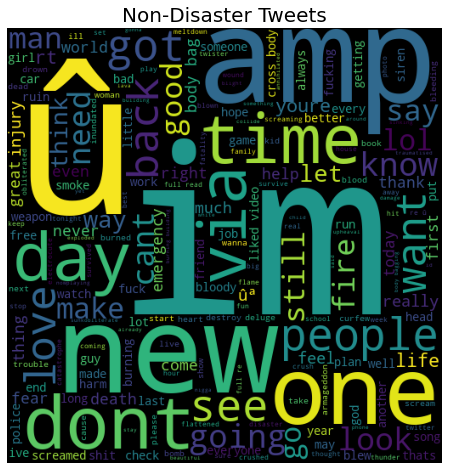

In [14]:
wordcloud(data_non_disaster,'Non-Disaster Tweets')

#### Disaster Tweets WordCloud

We can detect the words`flood`, `storm`, `fire`, `police` and so on, which might be associated with a disaster. 

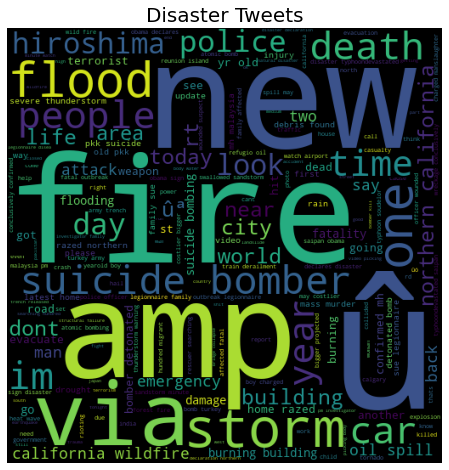

In [15]:
wordcloud(data_disaster,'Disaster Tweets')

### Showing top 10 unigrams and bigrams

In [16]:
def top_ngrams(data,n,grams):
    count_vec = CountVectorizer(ngram_range=(grams,grams)).fit(data)
    bow = count_vec.transform(data)
    add_words = bow.sum(axis=0)
    word_freq = [(word, add_words[0, idx]) for word, idx in count_vec.vocabulary_.items()]
    word_freq = sorted(word_freq, key = lambda x: x[1], reverse=True) 
    return word_freq[:n]

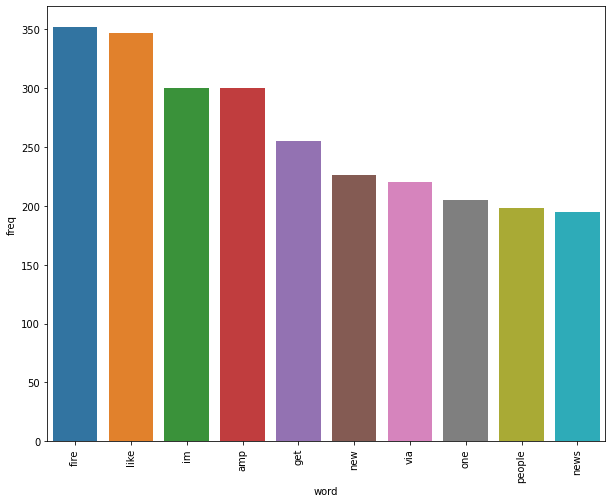

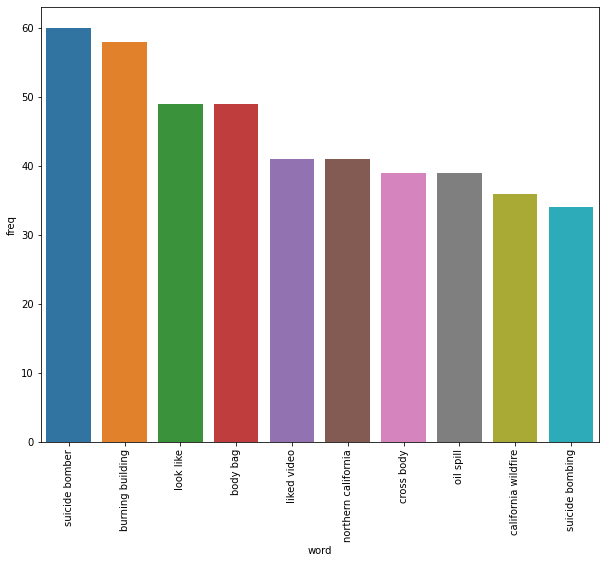

In [17]:
common_uni_df = pd.DataFrame(top_ngrams(data['cleansed'], 10, 1), columns=['word','freq'])
common_bi_df = pd.DataFrame(top_ngrams(data['cleansed'], 10, 2), columns=['word','freq'])

plt.figure(figsize=(10,8))
sns.barplot(x='word', y='freq', data=common_uni_df)
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(10,8))
sns.barplot(x='word', y='freq', data=common_bi_df)
plt.xticks(rotation=90)
plt.show()

## 5. Preprocessing Data

### Extracting the feature and label

In [18]:
X = data['cleansed']
y = data['target']

### Tokenizing the Texts

Tokenizing the texts. Tokenizing will split the texts into the vectors of words so that the computer can process them.

In [19]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X.values)
vocab_length = len(word_tokenizer.word_index) + 1

### Padding the Text

Padding the text so that each text has the same length.

In [20]:
longest_train = max(X.values, key=lambda text: len(word_tokenize(text)))
length_long_text = len(word_tokenize(longest_train))

# padding
padded_texts = pad_sequences(word_tokenizer.texts_to_sequences(X.values), length_long_text, padding='post')

### Creating the Embedding Word Matrix

We will create our own word matrix which return the vector of word (Vector Data Source: https://www.kaggle.com/danielwillgeorge/glove6b100dtxt)

In [21]:
embeddings_dictionary = dict()
embedding_dim = 100


TXT_PATH = '../input/glove6b100dtxt/glove.6B.100d.txt'

# loading the vectors of words from the file
with open(TXT_PATH) as f:
    for line in f:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions

# create matrix
embedding_matrix = np.zeros((vocab_length, embedding_dim))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## 6. Training Models

We will create two models in this section: a convolution neural network model and a multi-channel convolution neural network model.

### Spliting the Data for Train and Validation
We will split the data at the ratio below:
- train_size: 80% of the data
- validaton_size: 20% of the data

In [22]:
X_train, X_val, y_train, y_val = train_test_split(padded_texts, y.values, test_size=0.2, random_state=1)

In [23]:
# a helper function for showing model history
def model_history(model_history):
    epochs = list(range(1, len(model_history.history['accuracy']) + 1))
    # accuracy    
    data_preproc = pd.DataFrame({
        'epochs': epochs, 
        'accuracy': model_history.history['accuracy'],
        'val_accuracy': model_history.history['val_accuracy']
    })
    plt.figure(figsize=(8,6))
    ax = sns.lineplot(x='epochs', y='value', hue='variable', 
             data=pd.melt(data_preproc, ['epochs']))
    ax.set_title('model accuracy')
    plt.show()

    # loss    
    data_preproc = pd.DataFrame({
        'epochs': epochs, 
        'loss': model_history.history['loss'],
        'val_loss': model_history.history['val_loss']
    })
    plt.figure(figsize=(8,6))
    ax = sns.lineplot(x='epochs', y='value', hue='variable', 
             data=pd.melt(data_preproc, ['epochs']))
    ax.set_title('model loss')
    plt.show()

### Creating the Convolutional Neural Network

We will create a normal CNN model (single input) with the definition of the next code.

In [24]:
def create_cnn_model(hp):    
    model = Sequential()

    model.add(Embedding(vocab_length, 100, weights=[embedding_matrix],
                                     input_length=length_long_text,trainable=False))
    model.add(Conv1D(filters=hp.Int('conv_1_filter',min_value=21,max_value=200,step=14),
                                kernel_size=hp.Choice('conv_1_kernel',values=[3,4,5]),
                                activation='relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(units = hp.Int('dense_1',min_value=21,max_value=150,step=14), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))
  
    hp_learning_rate = hp.Choice('learning_rate', values=[3e-2, 3e-3, 3e-4, 3e-5])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model

Using Keras-Tuner(kt) to get the best hyperparameters.

In [25]:
tuner_cnn = kt.Hyperband(create_cnn_model,
                         objective='val_accuracy',
                         max_epochs=15,factor=5,
                         directory='cnn_model',
                         project_name='DisasterTweets',
                         overwrite=True)

In [26]:
stop_early = EarlyStopping(monitor='val_loss',
                           mode='min',
                           verbose=1,
                           patience=10)

tuner_cnn.search(X_train, y_train,
                 epochs=15,
                 validation_data=(X_val,y_val),
                 callbacks=[stop_early])

# Get the optimal hyperparameters
best_hyperparams_cnn = tuner_cnn.get_best_hyperparameters(num_trials=1)[0]

Trial 13 Complete [00h 00m 11s]
val_accuracy: 0.7984241843223572

Best val_accuracy So Far: 0.803676962852478
Total elapsed time: 00h 01m 16s


Creating a model using the best hyperparameters.

In [27]:
model_cnn = tuner_cnn.hypermodel.build(best_hyperparams_cnn)
# showing the model summary
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 23, 100)           1359700   
_________________________________________________________________
conv1d (Conv1D)              (None, 19, 105)           52605     
_________________________________________________________________
dropout (Dropout)            (None, 19, 105)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 9, 105)            0         
_________________________________________________________________
flatten (Flatten)            (None, 945)               0         
_________________________________________________________________
dense (Dense)                (None, 63)                59598     
_________________________________________________________________
dropout_1 (Dropout)          (None, 63)                0

In [28]:
# train
history_cnn = model_cnn.fit(X_train,
                            y_train,
                            epochs=50,
                            validation_data=(X_val,y_val),
                            callbacks=[stop_early])

Epoch 1/50
191/191 [==============================] - 1s 4ms/step - loss: 0.5578 - accuracy: 0.7139 - val_loss: 0.4676 - val_accuracy: 0.7853
Epoch 2/50
191/191 [==============================] - 1s 3ms/step - loss: 0.4311 - accuracy: 0.8125 - val_loss: 0.4561 - val_accuracy: 0.7991
Epoch 3/50
191/191 [==============================] - 1s 3ms/step - loss: 0.3886 - accuracy: 0.8345 - val_loss: 0.4721 - val_accuracy: 0.7886
Epoch 4/50
191/191 [==============================] - 1s 3ms/step - loss: 0.3327 - accuracy: 0.8557 - val_loss: 0.4879 - val_accuracy: 0.7833
Epoch 5/50
191/191 [==============================] - 1s 3ms/step - loss: 0.2744 - accuracy: 0.8816 - val_loss: 0.5518 - val_accuracy: 0.7722
Epoch 6/50
191/191 [==============================] - 1s 3ms/step - loss: 0.2451 - accuracy: 0.9075 - val_loss: 0.5424 - val_accuracy: 0.7774
Epoch 7/50
191/191 [==============================] - 1s 3ms/step - loss: 0.2004 - accuracy: 0.9270 - val_loss: 0.6374 - val_accuracy: 0.7899
Epoch 

Plotting the accuracy and loss history. **The validation accuracy is around 80% in the 2nd epoch**.

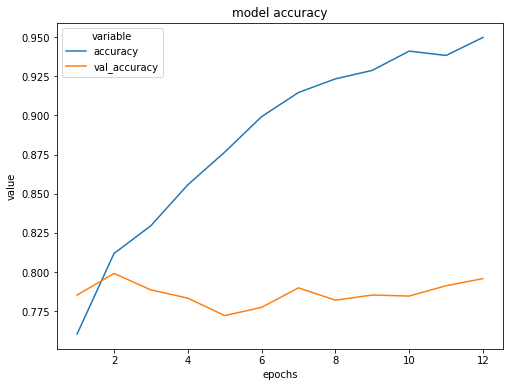

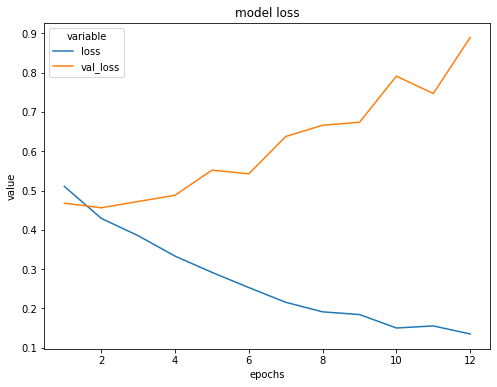

In [29]:
model_history(history_cnn)

### Creating the Multi-Channel Convolutional Neural Network

We will create a normal CNN model (double inputs) with the definition of the next code.

In [30]:
def create_multi_channel_cnn(hp):
    # input 1
    inputs1 = Input(shape=(length_long_text,))

    embedding1 = Embedding(vocab_length, 100, weights=[embedding_matrix],
                           input_length=length_long_text, trainable=False)(inputs1)     
    conv1 = Conv1D(filters=hp.Int('conv_1_filter',min_value=21,max_value=150,step=14),
                                kernel_size=hp.Choice('conv_1_kernel',values=[3,4,5,6,7,8]),
                                activation='relu')(embedding1) 
    drop1 = Dropout(0.3)(conv1) 
    pool1 = MaxPooling1D()(drop1) 
    flat1 = Flatten()(pool1)
    
    # input 2
    inputs2 = Input(shape=(length_long_text,)) 
    embedding2 = Embedding(vocab_length, 100, weights=[embedding_matrix],
                           input_length=length_long_text,trainable=False)(inputs2) 
    conv2 = Conv1D(filters=hp.Int('conv_2_filter',min_value=21,max_value=150,step=14),
                                kernel_size=hp.Choice('conv_2_kernel',values=[3,4,5,6,7,8]),
                                activation='relu')(embedding2) 
    drop2 = Dropout(0.3)(conv2) 
    pool2 = MaxPooling1D()(drop2) 
    flat2 = Flatten()(pool2) 
    
    # merge 
    merged = concatenate([flat1, flat2]) 
    
    dense1 = Dense(units = hp.Int('dense_1',min_value=21,max_value=120,step=14),
                               activation='relu')(merged)
    drop3 = Dropout(0.5)(dense1)
    
    outputs = Dense(1, activation='sigmoid')(drop3) 
    model = Model(inputs=[inputs1, inputs2], outputs=outputs) 
    
    hp_learning_rate = hp.Choice('learning_rate', values=[3e-2, 3e-3, 3e-4, 3e-5]) 
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model

Using Keras-Tuner(kt) to get the best hyperparameters.

In [31]:
tuner_mcnn = kt.Hyperband(create_multi_channel_cnn,
                          objective='val_accuracy',
                          max_epochs=15,factor=5,
                          directory='my_dir',
                          project_name='DisasterTweetsMCNN_kt',
                          overwrite=True)

In [32]:
stop_early = EarlyStopping(monitor='val_loss',
                           mode='min',
                           verbose=1,
                           patience=10)

tuner_mcnn.search([X_train,X_train],y_train, epochs=15,
                  validation_data=([X_val,X_val], y_val),
                  callbacks=[stop_early])

# Get the optimal hyperparameters
best_hyperparams_mcnn = tuner_mcnn.get_best_hyperparameters(num_trials=1)[0]

Trial 13 Complete [00h 00m 14s]
val_accuracy: 0.7839789986610413

Best val_accuracy So Far: 0.803676962852478
Total elapsed time: 00h 01m 32s


Creating a model using the best hyperparameters.

In [33]:
model_mcnn = tuner_mcnn.hypermodel.build(best_hyperparams_mcnn)
# showing the model summary
model_mcnn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 23)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 23)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 23, 100)      1359700     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 23, 100)      1359700     input_2[0][0]                    
______________________________________________________________________________________________

In [34]:
history_mcnn = model_mcnn.fit([X_train,X_train], y_train,epochs=50,
                              validation_data=([X_val,X_val], y_val),
                              callbacks=[stop_early])

Epoch 1/50
191/191 [==============================] - 2s 6ms/step - loss: 0.5646 - accuracy: 0.7302 - val_loss: 0.4698 - val_accuracy: 0.8004
Epoch 2/50
191/191 [==============================] - 1s 4ms/step - loss: 0.4249 - accuracy: 0.8079 - val_loss: 0.4569 - val_accuracy: 0.8030
Epoch 3/50
191/191 [==============================] - 1s 4ms/step - loss: 0.3519 - accuracy: 0.8489 - val_loss: 0.4928 - val_accuracy: 0.8050
Epoch 4/50
191/191 [==============================] - 1s 4ms/step - loss: 0.3133 - accuracy: 0.8644 - val_loss: 0.5539 - val_accuracy: 0.7833
Epoch 5/50
191/191 [==============================] - 1s 4ms/step - loss: 0.2623 - accuracy: 0.8824 - val_loss: 0.5708 - val_accuracy: 0.7833
Epoch 6/50
191/191 [==============================] - 1s 4ms/step - loss: 0.2156 - accuracy: 0.9072 - val_loss: 0.6130 - val_accuracy: 0.7715
Epoch 7/50
191/191 [==============================] - 1s 4ms/step - loss: 0.1728 - accuracy: 0.9404 - val_loss: 0.7256 - val_accuracy: 0.7807
Epoch 

Plotting the accuracy and loss history. **The validation accuracy is around 80% in the 1st epoch**.

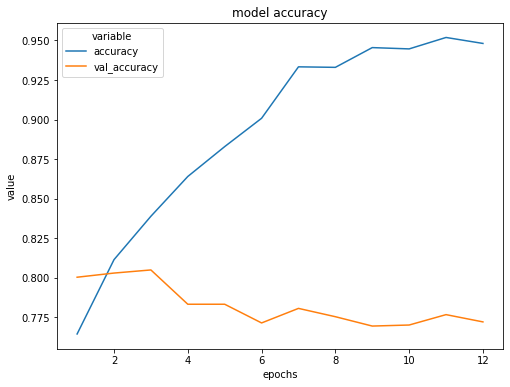

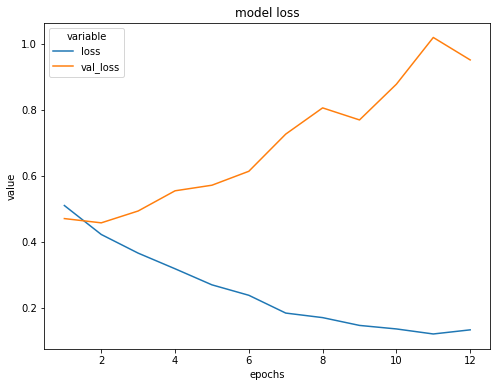

In [35]:
model_history(history_mcnn)

## Discussion

Both of the models have almost the same validation accuracy (around 80%) even though the number of inputs is different. Some causes might be:

- the quality of the provided data (raw data) is not high enough at first
- the data cleansing is not enough to remove 'noisy' words and symbols
- the model definition is not sophisticated because of my poor ability
- some of the methods including data manipulation and modeling to be used is not suitable for the task

In the next trial, we'd like to aim at 90% with a completely different approach.

### Kaggle Submission

In [36]:
# importaing test data
test = pd.read_csv('../input/nlp-getting-started/test.csv')

test["cleansed"] = test["text"].apply(preprocess_data)
test_sentences = pad_sequences(word_tokenizer.texts_to_sequences(test["cleansed"].values),
                               length_long_text,
                               padding='post')

In [37]:
# using the CNN model
preds = model_cnn.predict_classes(test_sentences)

submission = pd.concat([
    pd.DataFrame(test["id"]),
    pd.DataFrame(preds)
], axis=1)
submission.columns = ["id","target"]

submission.to_csv("submission.csv",index=False)